正波动率周期：由价格上涨带来的波动率增加

负波动率周期：由价格下跌带来的波动率增加


In [1]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt


In [2]:
all_futures = all_instruments("Future")
match = r'\w{1,2}88'
continuous_contracts = (all_futures[all_futures.order_book_id.str.contains(match)])
continuous_contracts = continuous_contracts.where(continuous_contracts["product"] == "Commodity").dropna(how="all")
all_commodities = sorted(set(continuous_contracts.where(continuous_contracts.de_listed_date == "0000-00-00").dropna(how="all").underlying_symbol))

In [ ]:
def get_periods(target,periods):
  _start_date = get_dominant_future(target).index.tolist()[0]
  _price = get_price(target+"88",_start_date,"2018-04-01",fields="close")
  if len(_price)>=200:
    _price_std = _price.rolling(window=periods).std()
    _price_std_mean = _price_std.rolling(window=periods).mean()
    _price_std_std = _price_std.rolling(window=periods).std()

    _price_periods = _price.shift(periods)
    _price_std_periods = _price_std.shift(periods)

    _combined_data = pd.concat([_price,_price_periods,_price_std,_price_std_mean,_price_std_std,_price_std_periods],axis=1)
    _combined_data.columns =['_price','_price_periods','_price_std','_price_std_mean','_price_std_std','_price_std_periods']

    def _get_periods_type(series):
  #     正周期 膨胀
      if series._price_std_periods < series._price_std_mean - series._price_std_std and series._price > series._price_periods and series._price_std > series._price_std_periods:
        return 2
  #     正周期 膨胀末期
      elif series._price_std_periods > series._price_std_mean + series._price_std_std and series._price < series._price_periods and series._price_std < series._price_std_periods:
        return 1
  #     负周期，膨胀
      elif series._price_std_periods < series._price_std_mean - series._price_std_std and series._price < series._price_periods and series._price_std > series._price_std_periods:
        return -1
      else:
        return 0

    return _combined_data.T.apply(_get_periods_type)
  else:
    return pd.Series(0,index=_price.index)

In [ ]:
def get_specific_rtns(series):
  _price = get_price(series['dominant'],series['date'],get_next_trading_date(series['date']),fields="close")
  return _price.iloc[-1]/_price.iloc[0]-1
commodities_price = {}
for i in rest:
  _dominants = get_dominant_future(i,"2005-01-04","2018-03-31")
  commodities_price[i] = pd.Series(_dominants.reset_index().iloc[:-2].T.apply(lambda x: get_specific_rtns(x)).values,index=_dominants.iloc[:-2].index)
# pickle the dominants returns 
all_commodities_price = pd.concat(commodities_price.values(),keys = commodities_price.keys()).unstack()
# all_commodities_price.to_pickle("dominants_rtns.pkl")

In [ ]:
all_comodities_periods_signal = {}
for i in all_commodities:
#   print(i)
  _periods_signal = {}
  for _periods in np.arange(10,120,10):
#     print(_periods)
    _periods_signal[_periods] = get_periods(i,_periods)
  _periods_signal = pd.concat(_periods_signal.values(),keys = _periods_signal.keys()).unstack()
  all_comodities_periods_signal[i] = _periods_signal
all_comodities_periods_signal = pd.concat(all_comodities_periods_signal.values(),keys = all_comodities_periods_signal.keys()).to_pickle("all_comodities_periods_signal.pkl")
# pickle the signal
# all_comodities_periods_signal.to_pickle("all_comodities_periods_signal.pkl")

start analyse!

In [3]:
# periods_signals
all_commodities_price = pd.read_pickle("dominants_rtns.pkl")
all_comodities_periods_signal = pd.read_pickle("all_comodities_periods_signal.pkl")

In [4]:
def calc_indicators(rets):
    def get_maxdrawdown(values): 
#       print(values)
      dd = [values[i:].min() / values[i] - 1 for i in range(len(values))]
      return abs(min(dd))
    cummulative_rtns = rets.add(1).cumprod()
#     print(cummulative_rtns)
    annulized_rtns = rets.mean()*250
    annulized_std = rets.std() * (250**0.5)
    sharpe = annulized_rtns/annulized_std
    maxdrawdown = get_maxdrawdown(cummulative_rtns.dropna().values)
    return pd.Series([annulized_rtns,annulized_std,sharpe,maxdrawdown],index=["年化收益",'年化标准差','夏普值','最大回撤'])

  

calculate top 20 liquity contracts 

In [5]:
continuous_contracts = [i+"88" for i in all_commodities]
codes2symbols = pd.Series(list(map(lambda x: instruments(x).symbol[:-4],continuous_contracts)),index=continuous_contracts)
liquity_contracts = pd.Series(list(map(lambda x: get_price(x,"2010-01-01","2018-01-01",fields="volume").mean(),continuous_contracts)),index=continuous_contracts)
liquity_contracts = liquity_contracts.reset_index().replace(codes2symbols.to_dict())
liquity_contracts = liquity_contracts.set_index("index")[0].sort_values(ascending=False).iloc[:20].index.tolist()
codes2symbols.index = codes2symbols.index.str.replace("88","")


In [6]:
def plot_performance_heatmap(ax,content,name):
  _fig = ax.pcolor(content,cmap = cm.RdYlGn_r)
#   ,cmap = cm.YlOrRd
  cbar = plt.colorbar(_fig,ax=ax)
  
  ax.set_xticks(np.arange(content.shape[1])+0.5)
  ax.set_yticks(np.arange(content.shape[0])+0.5)
  ax.set_xticklabels(content.columns.values.tolist())
  ax.set_yticklabels(content.index.values.tolist())
  ax.set_xlabel("窗口")
  ax.set_ylabel("商品")
  ax.set_title(name)

  
  
  

正波动周期均 看多


In [7]:
all_performance = {}
for i in all_commodities:
  _r = (all_comodities_periods_signal.loc[i].sort_index().T.replace([2,-1,np.nan],[1,0,0])).apply(lambda x: calc_indicators(x*all_commodities_price.loc[i])).T
  all_performance[i] = _r
all_performance = pd.concat(all_performance.values(),keys = all_performance.keys())

/opt/conda/envs/ricequant/bin/rq-research-kernel:10: RuntimeWarning: invalid value encountered in double_scalars
  sys.argv[0] = re.sub(r'(-script\.pyw?|\.exe)?$', '', sys.argv[0])


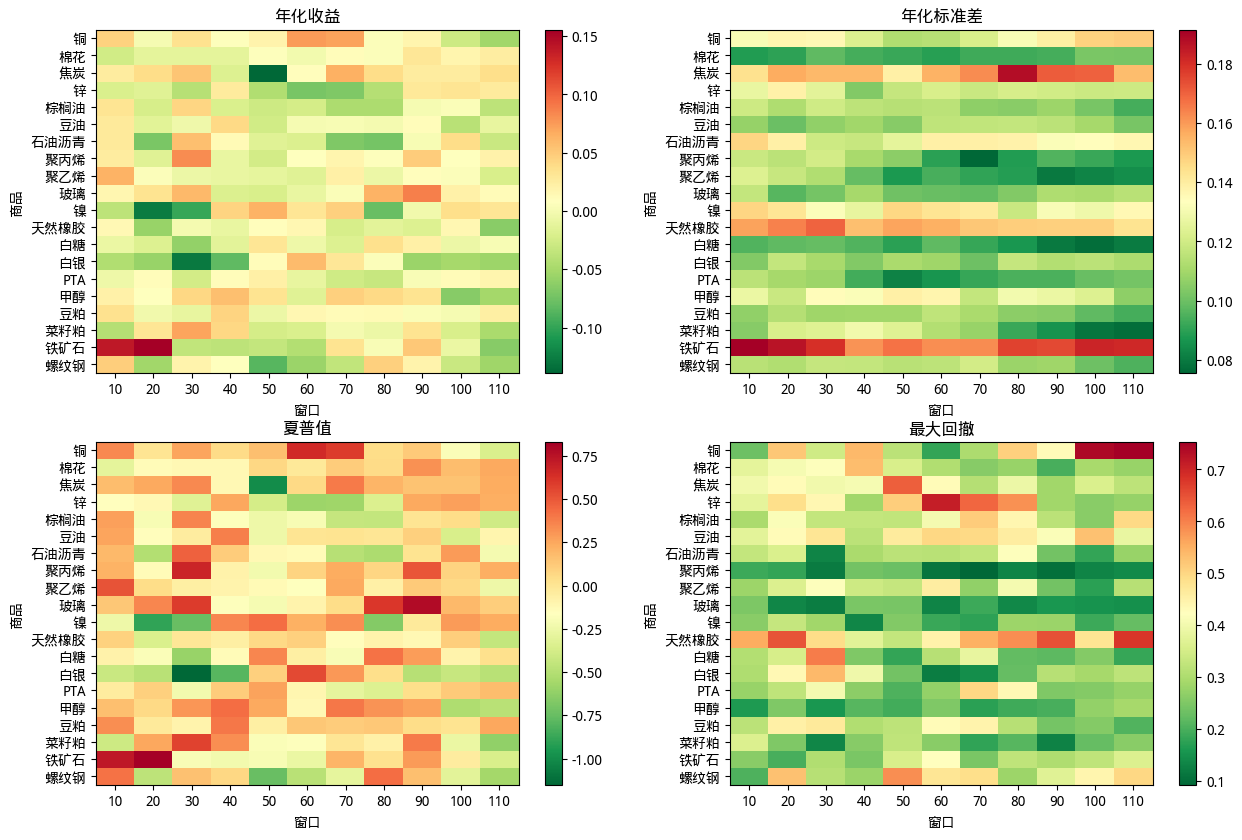

In [8]:
fig,ax = plt.subplots(2,2,figsize = (15,10))
for i,col in enumerate(all_performance.columns):
  x,y = int(i/2),i%2
  ax_ = ax[x][y]
  _ = all_performance[col].unstack()
  _ = _.reset_index().replace(codes2symbols.to_dict()).set_index("index").loc[liquity_contracts]
  plot_performance_heatmap(ax_,_,col)

只有正波动周期 且处于上升阶段看多

In [9]:
all_performance_2 = {}
for i in all_commodities:
  _r = (all_comodities_periods_signal.loc[i].sort_index().T.replace([2,1,-1,np.nan],[1,0,0,0])).apply(lambda x: calc_indicators(x*all_commodities_price.loc[i])).T
  all_performance_2[i] = _r
all_performance_2 = pd.concat(all_performance_2.values(),keys = all_performance_2.keys())

/opt/conda/envs/ricequant/bin/rq-research-kernel:10: RuntimeWarning: invalid value encountered in double_scalars
  sys.argv[0] = re.sub(r'(-script\.pyw?|\.exe)?$', '', sys.argv[0])


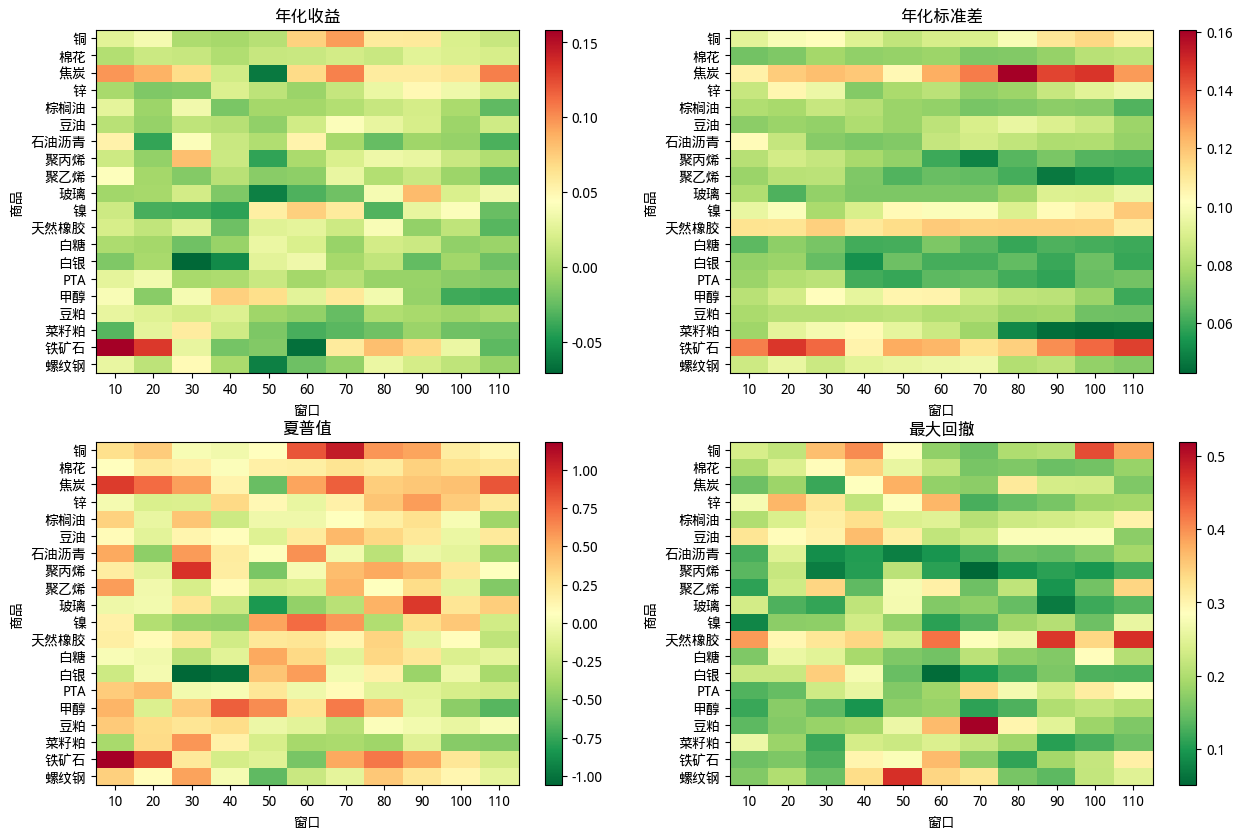

In [10]:
fig,ax = plt.subplots(2,2,figsize = (15,10))
for i,col in enumerate(all_performance_2.columns):
  x,y = int(i/2),i%2
  ax_ = ax[x][y]
  _ = all_performance_2[col].unstack()
  _ = _.reset_index().replace(codes2symbols.to_dict()).set_index("index").loc[liquity_contracts]
  plot_performance_heatmap(ax_,_,col)

In [19]:
diff_sharpe = (all_performance_2["夏普值"] -all_performance["夏普值"]).unstack().reset_index().replace(codes2symbols.to_dict()).set_index("index")
diff_sharpe = diff_sharpe.loc[liquity_contracts]

夏普之差 大于 0 的说明 只在正波动周期的上升期间 做多 对 在整个正波动期间 做多 有改善

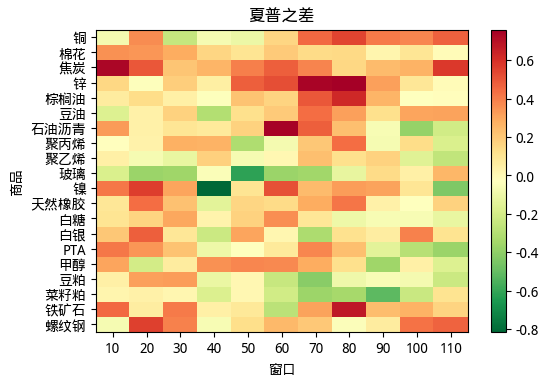

In [22]:
fig,ax = plt.subplots()
plot_performance_heatmap(ax,diff_sharpe,"夏普之差")

在 负波动区间做多

In [23]:
all_performance_3 = {}
for i in all_commodities:
  _r = (all_comodities_periods_signal.loc[i].sort_index().T.replace([2,1,-1,np.nan],[0,0,1,0])).apply(lambda x: calc_indicators(x*all_commodities_price.loc[i])).T
  all_performance_3[i] = _r
all_performance_3 = pd.concat(all_performance_3.values(),keys = all_performance_3.keys())

/opt/conda/envs/ricequant/bin/rq-research-kernel:10: RuntimeWarning: invalid value encountered in double_scalars
  sys.argv[0] = re.sub(r'(-script\.pyw?|\.exe)?$', '', sys.argv[0])


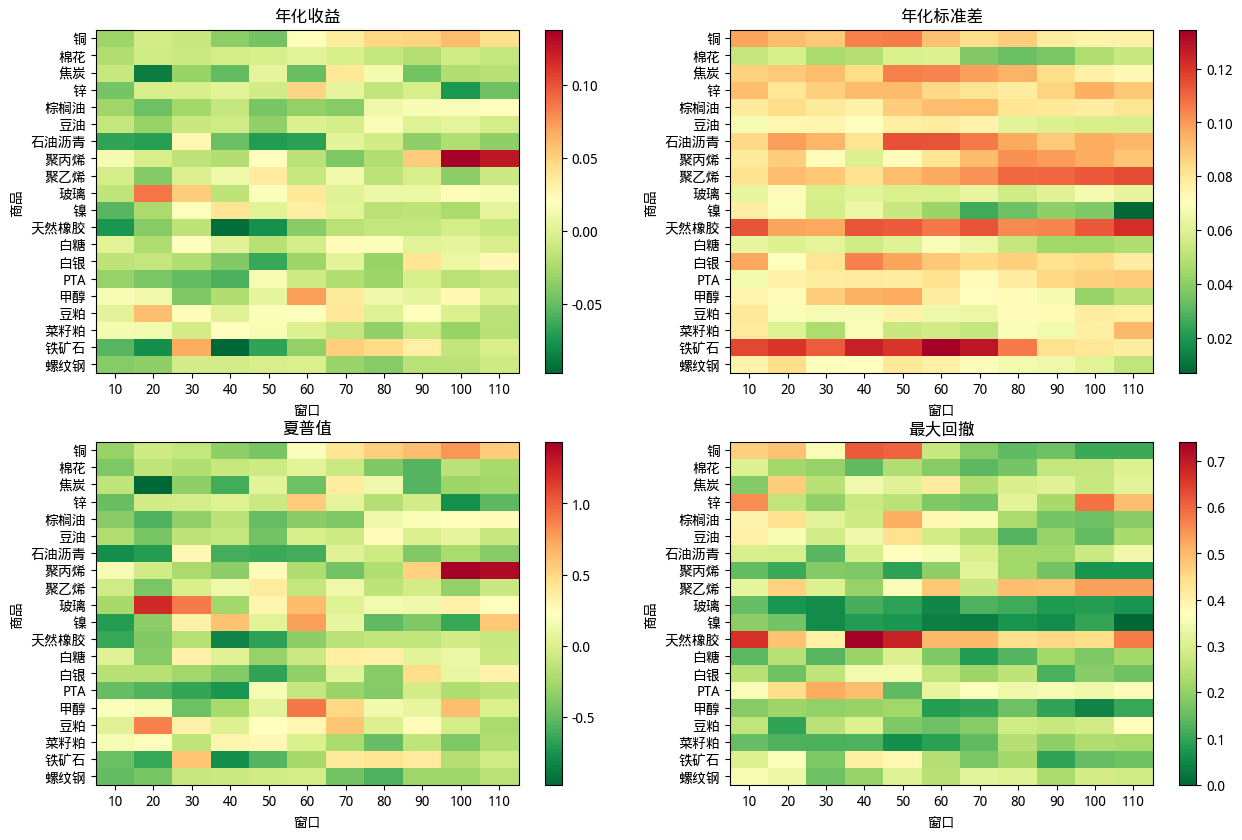

In [24]:
fig,ax = plt.subplots(2,2,figsize = (15,10))
for i,col in enumerate(all_performance_3.columns):
  x,y = int(i/2),i%2
  ax_ = ax[x][y]
  _ = all_performance_3[col].unstack()
  _ = _.reset_index().replace(codes2symbols.to_dict()).set_index("index").loc[liquity_contracts]
  plot_performance_heatmap(ax_,_,col)

look at the sharpe,distinguish the volatility periods seems to be effective

BUT, different contracts suitable for different parameters